In [ ]:
# exploring clinical variables

In [1]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import collections
import asyncio
import getpass
import re
from datetime import datetime as dt
import os,sys,re
import urllib3
import prettytable
from collections import Counter
import seaborn as sns
import random

from sklearn.externals.joblib import Memory
memory = Memory(cachedir='/tmp', verbose=0)
#@memory.cache above any def fxn.

%matplotlib inline
plt.style.use('ggplot')

from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})

%load_ext autotime

/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [4]:
#establishing a connection to Dr. Luo's mimic database server, remember to connect to nu vpn first.

import psycopg2
# conn = psycopg2.connect(dbname="mimic", user="student", password="lipup", host="luolabwkstn01.fsm.northwestern.edu", port="5432")
# cur=conn.cursor()

conn = psycopg2.connect(dbname="mimic", user="student", host="luolabwkstn01.fsm.northwestern.edu", port="5432",
                        password=getpass.getpass(prompt='Password:'.format()))
cur=conn.cursor()

query_schema = 'SET search_path to ' + "mimiciii" + ';'

OperationalError: could not connect to server: Connection refused
	Is the server running on host "luolabwkstn01.fsm.northwestern.edu" (165.124.146.43) and accepting
	TCP/IP connections on port 5432?


time: 8.02 s


In [3]:
import os
cwd= os.getcwd()

time: 1.01 ms


In [3]:
cwd

'/Users/geickelb1'

time: 3.28 ms


In [18]:
#importing clinical variable csv
#lab = f'data/interim/{today}-winemag_priceGBP.csv'

#/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/notebooks

labs_all48=  pd.read_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/wrangled/labs_all48_df.csv', index_col=0)
bg_all48=  pd.read_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/wrangled/labs_all48_df.csv', index_col=0)
vital_all48=  pd.read_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/wrangled/vital_all48_df.csv', index_col=0)
cohort_df = pd.read_csv('/Users/geickelb1/Desktop/PhD_Misc/HSIP_442_Yuan_Lao/final_pt_df2_5-04-18.csv', index_col=0)
#final_pt_df2 = pd.read_csv('/Users/geickelb1/Desktop/PhD_Misc/HSIP_442_Yuan_Lao/final_pt_df2_5-04-18.csv', index_col=0)


/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


time: 12.1 s


In [20]:
labs_all48.head()

,subject_id,hadm_id,icustay_id,charttime,label,valuenum
0,4,185777,294638,2191-03-15 21:23:00,HEMATOCRIT,32.0
1,4,185777,294638,2191-03-15 21:23:00,HEMOGLOBIN,10.5
2,4,185777,294638,2191-03-15 21:23:00,LACTATE,2.1
3,4,185777,294638,2191-03-16 05:42:00,ALBUMIN,2.8
4,4,185777,294638,2191-03-16 05:42:00,ANION GAP,15.0


time: 14.4 ms


In [22]:
labs_all48.describe(include ='all', ) #the .T transposes the data. makes more sense. 

,subject_id,hadm_id,icustay_id,charttime,label,valuenum
count,1.396199e+06,1.396199e+06,1.396199e+06,1354760,1354760,1.354746e+06
unique,NaN,NaN,NaN,192695,19,NaN
top,NaN,NaN,NaN,2141-04-15 20:12:00,POTASSIUM,NaN
freq,NaN,NaN,NaN,36,116162,NaN
mean,3.694985e+04,1.499390e+05,2.500838e+05,NaN,NaN,5.211095e+01
std,2.888935e+04,2.892039e+04,2.892764e+04,NaN,NaN,7.412202e+01
min,2.000000e+00,1.000010e+05,2.000010e+05,NaN,NaN,5.000000e-02
25%,1.359300e+04,1.249610e+05,2.249700e+05,NaN,NaN,5.500000e+00
50%,2.708900e+04,1.497480e+05,2.501520e+05,NaN,NaN,2.000000e+01
75%,5.988900e+04,1.749250e+05,2.750980e+05,NaN,NaN,9.600000e+01


time: 849 ms


In [47]:
(labs_all48.groupby(['label'])['valuenum','label'].describe())

#['subject_id','valuenum','label']

valuenum                                                      \
                count        mean         std    min    25%    50%    75%   
label                                                                       
ALBUMIN       15848.0    2.977044    0.672785   1.00    2.5    3.0    3.4   
ANION GAP     77703.0   14.765826    4.615240   2.00   12.0   14.0   17.0   
BANDS          5488.0   10.119625   10.354165   1.00    3.0    7.0   14.0   
BICARBONATE   79216.0   23.527600    5.514749   2.00   20.0   23.0   27.0   
BILIRUBIN     24141.0    2.709975    5.513684   0.10    0.4    0.8    2.3   
BUN           80542.0   32.205408   24.987569   1.00   15.0   24.0   42.0   
CHLORIDE      91528.0  104.720415    7.175859   1.70  100.0  105.0  109.0   
CREATININE    80822.0    1.826306    1.893652   0.05    0.8    1.2    2.0   
GLUCOSE      110745.0  145.446301   79.708047   1.55  103.0  127.0  163.0   
HEMATOCRIT   109928.0   30.705768    5.648967   4.00   27.0   30.1   34.0   
HEMOGLOBIN    91233.0   10.386708    1.973905   1.20    9.0   10.2   11.6   
INR           57096.0    1.705592    1.295775   0.10    1.2    1.3    1.7   
LACTATE       52350.0    2.897416    2.637821   0.05    1.3    2.0    3.4   
PLATELET      76649.0  212.137719  128.915616   5.00  123.0  190.0  271.0   
POTASSIUM    116161.0    4.234731    0.804294   0.70    3.7    4.1    4.6   
PT            57124.0   17.540767    9.351809   2.39   13.4   14.9   18.0   
PTT           58672.0   42.336277   25.462199  12.60   28.2   33.7   44.7   
SODIUM        95852.0  138.365344    5.639938  96.00  135.0  138.0  141.0   
WBC           73648.0   12.374483    9.549499   0.10    7.4   10.7   15.1   

                     
                max  
label                
ALBUMIN         5.7  
ANION GAP      77.0  
BANDS          86.0  
BICARBONATE    53.0  
BILIRUBIN      82.2  
BUN           272.0  
CHLORIDE      198.0  
CREATININE     46.6  
GLUCOSE      2440.0  
HEMATOCRIT     62.0  
HEMOGLOBIN     20.9  
INR            48.8  
LACTATE        32.0  
PLATELET     1608.0  
POTASSIUM      27.5  
PT            150.0  
PTT           150.0  
SODIUM        183.0  
WBC           471.7

time: 375 ms


# descriptive statistics for cohort. notes


get the missingness % for each variable (ie for each variable how many patients never have any entry?). repeat above for all variables. 

### NEED TO DOUBLE CHECK THAT THESE ICUSTAY ID ARE ONLY FOR THOSE INCLUDED IN STUDY



In [83]:
#labs_all48[1:1000].groupby(['subject_id', 'label'])['valuenum'].isnull()

#drop duplicates for all 

#s.isnull().sum()

lab_na_testvar = labs_all48.loc[labs_all48.loc[:,'valuenum'].isnull(),['subject_id','label']]

lab_na_testvar.value_counts()
#wine['country'].nunique()

AttributeError: 'DataFrame' object has no attribute 'value_counts'

time: 13.5 ms


In [51]:
labs_all48['label'].isnull().sum()

AttributeError: Cannot access callable attribute 'isnull' of 'DataFrameGroupBy' objects, try using the 'apply' method

time: 10.1 ms


In [89]:
icustay_list= list(cohort_df['icustay_id'].unique())

time: 4.28 ms


In [103]:
#task: get the missingness % for each variable (ie for each variable how many patients never have any entry?)

#lab_na_testvar = labs_all48.loc[labs_all48.loc[:,'valuenum'].isnull(),['subject_id','label']]

#lab_na_testvar.value_counts()


####FIRST THINGS FIRST, FILTER ONLY TO ICUSTAY OF INTEREST.

labs_all48= labs_all48[labs_all48['icustay_id'].isin(icustay_list)] #good


#my strat, drop na from labs_all48, then drop duplicate for each patient lab.


labs_all48_notnull= labs_all48[labs_all48['valuenum'].notnull()]

#labs_all48_notnull.groupby(['subject_id'])['label'].count()
labs_all48_notnull.drop_duplicates(['subject_id','label'])['label'].value_counts()
#labs_all48['subject_id'].nunique()
#labs_all48['subject_id','icustay_id','charttime','label','valuenum'.dropna()

CHLORIDE       11415
GLUCOSE        11415
SODIUM         11415
POTASSIUM      11415
BUN            11414
CREATININE     11414
BICARBONATE    11410
HEMATOCRIT     11408
WBC            11406
PLATELET       11405
HEMOGLOBIN     11404
ANION GAP      11395
PT             10771
INR            10767
PTT            10738
LACTATE         8947
BILIRUBIN       7451
ALBUMIN         6457
BANDS           2626
Name: label, dtype: int64

time: 181 ms


In [136]:
%whos

Variable        Type             Data/Info
------------------------------------------
ConfigManager   MetaHasTraits    <class 'notebook.services<...>g.manager.ConfigManager'>
Counter         type             <class 'collections.Counter'>
Memory          type             <class 'sklearn.externals.joblib.memory.Memory'>
asyncio         module           <module 'asyncio' from '/<...>3.6/asyncio/__init__.py'>
bg_all48        DataFrame                 subject_id  hadm<...>1396199 rows x 6 columns]
cm              ConfigManager    <notebook.services.config<...>er object at 0x10ab9bc50>
cohort_df       DataFrame               subject_id  icusta<...>[11493 rows x 15 columns]
collections     module           <module 'collections' fro<...>collections/__init__.py'>
dt              type             <class 'datetime.datetime'>
final_pt_df2    DataFrame               subject_id  icusta<...>[11493 rows x 15 columns]
getpass         module           <module 'getpass' from '/<...>ib/python3.6/getpass.p

In [102]:
labs_all48_notnull['subject_id'].nunique()

11417

time: 13.7 ms


In [162]:
"""
    get the # of filled vs missign values for each variable for our cohort.
    Args:
    -----
    df: dataframe
        name of dataframe initialized in this workbook
    valuenum_col: string
        name of column with the numerical or text variable in question
    label_col: string
        name of column with the lab value label in question
    Returns:
    -----
    filled_summary: df
        list of all variables with # filled values
    missing_summary: df
        list of all variables with # missing values
    percent_summary: df
        list of all variables with # filled values/ # total patients
    """

def missing_fxn(df, valuenum_col, label_col):
    if 'icustay_id' in list(df):
        df= df[df['icustay_id'].isin(list(cohort_df['icustay_id'].unique()))] #good
    else:
        df= df[df['subject_id'].isin(
            list(cohort_df['subject_id'].unique()))] 

    df_notnull = df[df[valuenum_col].notnull()]
    df_null = df[df[valuenum_col].isnull()]
    df_filtered = df.drop_duplicates(['subject_id',label_col])[label_col].value_counts()
    
    filled_summary= df_notnull.drop_duplicates(['subject_id',label_col])[label_col].value_counts()
    missing_summary = df_null.drop_duplicates(['subject_id',label_col])[label_col].value_counts()
    percent_summary = 100*(filled_summary / df_filtered)
    
    #missing_plot=(missing_summary.sort_index().plot.bar(title = f'# of missing values in {df}'))
    
    #filled_summary, missing_summary, percent_summary, 
    return(filled_summary, missing_summary, percent_summary)

time: 22.1 ms


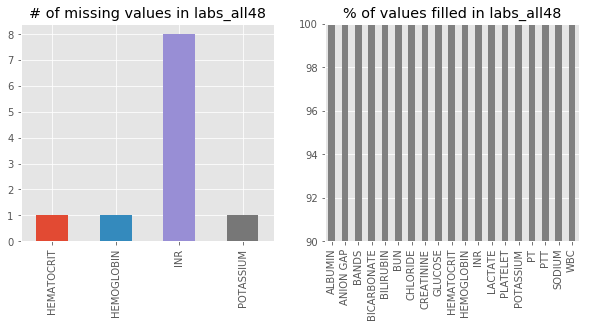

time: 795 ms


In [201]:
#labs
var1, var2, var3,  = missing_fxn(labs_all48, 'valuenum', 'label')
fig, axs = plt.subplots(1,2,figsize=(10,4))
ax1= (var2.sort_index().plot.bar(ax=axs[0], title = '# of missing values in labs_all48'))
ax2= (var3.sort_index().plot.bar(color='grey',
                                ax=axs[1],
                                ylim=(min(var3)-10 ,100),
                                title = '% of values filled in labs_all48'))

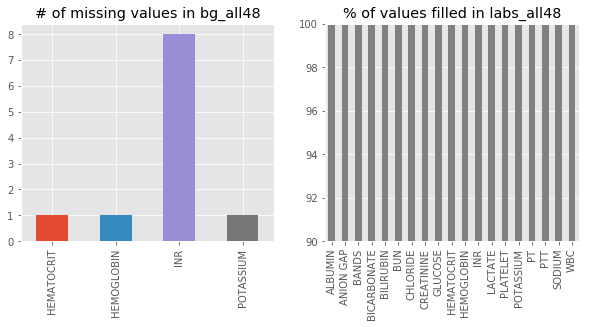

time: 721 ms


In [203]:
#bloodgas, is exact same as labs, 2xcheck
del var1, var2, var3
var1, var2, var3,  = missing_fxn(bg_all48, 'valuenum', 'label')
fig, axs = plt.subplots(1,2,figsize=(10,4))
ax1= (var2.sort_index().plot.bar(ax=axs[0], title = '# of missing values in bg_all48'))
ax2= (var3.sort_index().plot.bar(color='grey',
                                ax=axs[1],
                                ylim=(min(var3)-10 ,100),
                                title = '% of values filled in labs_all48'))

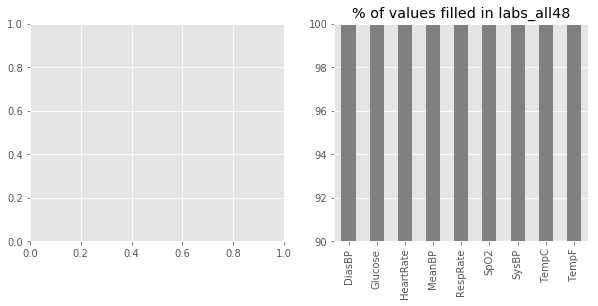

time: 2.08 s


In [223]:

del var1, var2, var3
var1, var2, var3,  = missing_fxn(vital_all48, 'valuenum', 'vitalid')
fig, axs = plt.subplots(1,2,figsize=(10,4))
if var2.notnull == True: 
    ax1= (var2.sort_index().plot.bar(ax=axs[0], title = '# of missing values in vital_all48'))
ax2= (var3.sort_index().plot.bar(color='grey',
                                ax=axs[1],
                                ylim=(min(var3)-10 ,100),
                                title = '% of values filled in labs_all48'))




In [ ]:
labs_by_pt

In [ ]:
# cnt = (wine.groupby(
#     ['country','points'])['price'].agg(['count','min','max','mean']
#                                       ).sort_values(by = 'mean',ascending = False)[:10]
# )



In [226]:
#bg_all48 #1396199 rows × 6 columns
#labs_all48 # 817014 rows × 6 columns
labs_all48.loc[labs_all48.loc[:,'label']=='BICARBONATE',:]

,subject_id,hadm_id,icustay_id,charttime,label,valuenum
5,4,185777,294638,2191-03-16 05:42:00,BICARBONATE,21.0
21,4,185777,294638,2191-03-17 06:00:00,BICARBONATE,21.0
36,19,109235,273430,2108-08-06 01:08:00,BICARBONATE,22.0
51,19,109235,273430,2108-08-07 05:07:00,BICARBONATE,21.0
155,21,111970,216859,2135-01-30 19:05:00,BICARBONATE,23.0
173,21,111970,216859,2135-01-31 05:20:00,BICARBONATE,24.0
189,21,111970,216859,2135-02-01 02:59:00,BICARBONATE,20.0
204,25,129635,203487,2160-11-02 01:05:00,BICARBONATE,23.0
219,25,129635,203487,2160-11-02 03:59:00,BICARBONATE,21.0
230,25,129635,203487,2160-11-02 06:56:00,BICARBONATE,24.0


time: 189 ms


In [227]:
import psycopg2
# conn = psycopg2.connect(dbname="mimic", user="student", password="lipup", host="luolabwkstn01.fsm.northwestern.edu", port="5432")
# cur=conn.cursor()

conn = psycopg2.connect(dbname="mimic", user="student", host="luolabwkstn01.fsm.northwestern.edu", port="5432",
                        password=getpass.getpass(prompt='Password:'.format()))
cur=conn.cursor()

query_schema = 'SET search_path to ' + "mimiciii" + ';'

time: 2.54 s


In [229]:
# trying to get sofa score and variables associated
   


sofa_test_sql = query_schema + """
--DROP MATERIALIZED VIEW IF EXISTS SOFA CASCADE;
CREATE MATERIALIZED VIEW SOFA AS
with wt AS
(
  SELECT ie.icustay_id
    -- ensure weight is measured in kg
    , avg(CASE
        WHEN itemid IN (762, 763, 3723, 3580, 226512)
          THEN valuenum
        -- convert lbs to kgs
        WHEN itemid IN (3581)
          THEN valuenum * 0.45359237
        WHEN itemid IN (3582)
          THEN valuenum * 0.0283495231
        ELSE null
      END) AS weight

  from icustays ie
  left join chartevents c
    on ie.icustay_id = c.icustay_id
  WHERE valuenum IS NOT NULL
  AND itemid IN
  (
    762, 763, 3723, 3580,                     -- Weight Kg
    3581,                                     -- Weight lb
    3582,                                     -- Weight oz
    226512 -- Metavision: Admission Weight (Kg)
  )
  AND valuenum != 0
  and charttime between ie.intime - interval '1' day and ie.intime + interval '1' day
  -- exclude rows marked as error
  AND c.error IS DISTINCT FROM 1
  group by ie.icustay_id
)
-- 5% of patients are missing a weight, but we can impute weight using their echo notes
, echo2 as(
  select ie.icustay_id, avg(weight * 0.45359237) as weight
  from icustays ie
  left join echodata echo
    on ie.hadm_id = echo.hadm_id
    and echo.charttime > ie.intime - interval '7' day
    and echo.charttime < ie.intime + interval '1' day
  group by ie.icustay_id
)
, vaso_cv as
(
  select ie.icustay_id
    -- case statement determining whether the ITEMID is an instance of vasopressor usage
    , max(case
            when itemid = 30047 then rate / coalesce(wt.weight,ec.weight) -- measured in mcgmin
            when itemid = 30120 then rate -- measured in mcgkgmin ** there are clear errors, perhaps actually mcgmin
            else null
          end) as rate_norepinephrine

    , max(case
            when itemid =  30044 then rate / coalesce(wt.weight,ec.weight) -- measured in mcgmin
            when itemid in (30119,30309) then rate -- measured in mcgkgmin
            else null
          end) as rate_epinephrine

    , max(case when itemid in (30043,30307) then rate end) as rate_dopamine
    , max(case when itemid in (30042,30306) then rate end) as rate_dobutamine

  from icustays ie
  inner join inputevents_cv cv
    on ie.icustay_id = cv.icustay_id and cv.charttime between ie.intime and ie.intime + interval '1' day
  left join wt
    on ie.icustay_id = wt.icustay_id
  left join echo2 ec
    on ie.icustay_id = ec.icustay_id
  where itemid in (30047,30120,30044,30119,30309,30043,30307,30042,30306)
  and rate is not null
  group by ie.icustay_id
)
, vaso_mv as
(
  select ie.icustay_id
    -- case statement determining whether the ITEMID is an instance of vasopressor usage
    , max(case when itemid = 221906 then rate end) as rate_norepinephrine
    , max(case when itemid = 221289 then rate end) as rate_epinephrine
    , max(case when itemid = 221662 then rate end) as rate_dopamine
    , max(case when itemid = 221653 then rate end) as rate_dobutamine
  from icustays ie
  inner join inputevents_mv mv
    on ie.icustay_id = mv.icustay_id and mv.starttime between ie.intime and ie.intime + interval '1' day
  where itemid in (221906,221289,221662,221653)
  -- 'Rewritten' orders are not delivered to the patient
  and statusdescription != 'Rewritten'
  group by ie.icustay_id
)
, pafi1 as
(
  -- join blood gas to ventilation durations to determine if patient was vent
  select bg.icustay_id, bg.charttime
  , PaO2FiO2
  , case when vd.icustay_id is not null then 1 else 0 end as IsVent
  from bloodgasfirstdayarterial bg
  left join ventdurations vd
    on bg.icustay_id = vd.icustay_id
    and bg.charttime >= vd.starttime
    and bg.charttime <= vd.endtime
  order by bg.icustay_id, bg.charttime
)
, pafi2 as
(
  -- because pafi has an interaction between vent/PaO2:FiO2, we need two columns for the score
  -- it can happen that the lowest unventilated PaO2/FiO2 is 68, but the lowest ventilated PaO2/FiO2 is 120
  -- in this case, the SOFA score is 3, *not* 4.
  select icustay_id
  , min(case when IsVent = 0 then PaO2FiO2 else null end) as PaO2FiO2_novent_min
  , min(case when IsVent = 1 then PaO2FiO2 else null end) as PaO2FiO2_vent_min
  from pafi1
  group by icustay_id
)
-- Aggregate the components for the score
, scorecomp as
(
select ie.icustay_id
  , v.MeanBP_Min
  , coalesce(cv.rate_norepinephrine, mv.rate_norepinephrine) as rate_norepinephrine
  , coalesce(cv.rate_epinephrine, mv.rate_epinephrine) as rate_epinephrine
  , coalesce(cv.rate_dopamine, mv.rate_dopamine) as rate_dopamine
  , coalesce(cv.rate_dobutamine, mv.rate_dobutamine) as rate_dobutamine

  , l.Creatinine_Max
  , l.Bilirubin_Max
  , l.Platelet_Min

  , pf.PaO2FiO2_novent_min
  , pf.PaO2FiO2_vent_min

  , uo.UrineOutput

  , gcs.MinGCS
from icustays ie
left join vaso_cv cv
  on ie.icustay_id = cv.icustay_id
left join vaso_mv mv
  on ie.icustay_id = mv.icustay_id
left join pafi2 pf
 on ie.icustay_id = pf.icustay_id
left join vitalsfirstday v
  on ie.icustay_id = v.icustay_id
left join labsfirstday l
  on ie.icustay_id = l.icustay_id
left join uofirstday uo
  on ie.icustay_id = uo.icustay_id
left join gcsfirstday gcs
  on ie.icustay_id = gcs.icustay_id
)
, scorecalc as
(
  -- Calculate the final score
  -- note that if the underlying data is missing, the component is null
  -- eventually these are treated as 0 (normal), but knowing when data is missing is useful for debugging
  select icustay_id
  -- Respiration
  , case
      when PaO2FiO2_vent_min   < 100 then 4
      when PaO2FiO2_vent_min   < 200 then 3
      when PaO2FiO2_novent_min < 300 then 2
      when PaO2FiO2_novent_min < 400 then 1
      when coalesce(PaO2FiO2_vent_min, PaO2FiO2_novent_min) is null then null
      else 0
    end as respiration

  -- Coagulation
  , case
      when platelet_min < 20  then 4
      when platelet_min < 50  then 3
      when platelet_min < 100 then 2
      when platelet_min < 150 then 1
      when platelet_min is null then null
      else 0
    end as coagulation

  -- Liver
  , case
      -- Bilirubin checks in mg/dL
        when Bilirubin_Max >= 12.0 then 4
        when Bilirubin_Max >= 6.0  then 3
        when Bilirubin_Max >= 2.0  then 2
        when Bilirubin_Max >= 1.2  then 1
        when Bilirubin_Max is null then null
        else 0
      end as liver

  -- Cardiovascular
  , case
      when rate_dopamine > 15 or rate_epinephrine >  0.1 or rate_norepinephrine >  0.1 then 4
      when rate_dopamine >  5 or rate_epinephrine <= 0.1 or rate_norepinephrine <= 0.1 then 3
      when rate_dopamine >  0 or rate_dobutamine > 0 then 2
      when MeanBP_Min < 70 then 1
      when coalesce(MeanBP_Min, rate_dopamine, rate_dobutamine, rate_epinephrine, rate_norepinephrine) is null then null
      else 0
    end as cardiovascular

  -- Neurological failure (GCS)
  , case
      when (MinGCS >= 13 and MinGCS <= 14) then 1
      when (MinGCS >= 10 and MinGCS <= 12) then 2
      when (MinGCS >=  6 and MinGCS <=  9) then 3
      when  MinGCS <   6 then 4
      when  MinGCS is null then null
  else 0 end
    as cns

  -- Renal failure - high creatinine or low urine output
  , case
    when (Creatinine_Max >= 5.0) then 4
    when  UrineOutput < 200 then 4
    when (Creatinine_Max >= 3.5 and Creatinine_Max < 5.0) then 3
    when  UrineOutput < 500 then 3
    when (Creatinine_Max >= 2.0 and Creatinine_Max < 3.5) then 2
    when (Creatinine_Max >= 1.2 and Creatinine_Max < 2.0) then 1
    when coalesce(UrineOutput, Creatinine_Max) is null then null
  else 0 end
    as renal
  from scorecomp
)
select ie.subject_id, ie.hadm_id, ie.icustay_id
  -- Combine all the scores to get SOFA
  -- Impute 0 if the score is missing
  , coalesce(respiration,0)
  + coalesce(coagulation,0)
  + coalesce(liver,0)
  + coalesce(cardiovascular,0)
  + coalesce(cns,0)
  + coalesce(renal,0)
  as SOFA
, respiration
, coagulation
, liver
, cardiovascular
, cns
, renal
from icustays ie
left join scorecalc s
  on ie.icustay_id = s.icustay_id
order by ie.icustay_id;


"""

    
sofa_test_df=pd.read_sql_query(sofa_test_sql,conn) 

DatabaseError: Execution failed on sql 'SET search_path to mimiciii;
--DROP MATERIALIZED VIEW IF EXISTS SOFA CASCADE;
CREATE MATERIALIZED VIEW SOFA AS
with wt AS
(
  SELECT ie.icustay_id
    -- ensure weight is measured in kg
    , avg(CASE
        WHEN itemid IN (762, 763, 3723, 3580, 226512)
          THEN valuenum
        -- convert lbs to kgs
        WHEN itemid IN (3581)
          THEN valuenum * 0.45359237
        WHEN itemid IN (3582)
          THEN valuenum * 0.0283495231
        ELSE null
      END) AS weight

  from icustays ie
  left join chartevents c
    on ie.icustay_id = c.icustay_id
  WHERE valuenum IS NOT NULL
  AND itemid IN
  (
    762, 763, 3723, 3580,                     -- Weight Kg
    3581,                                     -- Weight lb
    3582,                                     -- Weight oz
    226512 -- Metavision: Admission Weight (Kg)
  )
  AND valuenum != 0
  and charttime between ie.intime - interval '1' day and ie.intime + interval '1' day
  -- exclude rows marked as error
  AND c.error IS DISTINCT FROM 1
  group by ie.icustay_id
)
-- 5% of patients are missing a weight, but we can impute weight using their echo notes
, echo2 as(
  select ie.icustay_id, avg(weight * 0.45359237) as weight
  from icustays ie
  left join echodata echo
    on ie.hadm_id = echo.hadm_id
    and echo.charttime > ie.intime - interval '7' day
    and echo.charttime < ie.intime + interval '1' day
  group by ie.icustay_id
)
, vaso_cv as
(
  select ie.icustay_id
    -- case statement determining whether the ITEMID is an instance of vasopressor usage
    , max(case
            when itemid = 30047 then rate / coalesce(wt.weight,ec.weight) -- measured in mcgmin
            when itemid = 30120 then rate -- measured in mcgkgmin ** there are clear errors, perhaps actually mcgmin
            else null
          end) as rate_norepinephrine

    , max(case
            when itemid =  30044 then rate / coalesce(wt.weight,ec.weight) -- measured in mcgmin
            when itemid in (30119,30309) then rate -- measured in mcgkgmin
            else null
          end) as rate_epinephrine

    , max(case when itemid in (30043,30307) then rate end) as rate_dopamine
    , max(case when itemid in (30042,30306) then rate end) as rate_dobutamine

  from icustays ie
  inner join inputevents_cv cv
    on ie.icustay_id = cv.icustay_id and cv.charttime between ie.intime and ie.intime + interval '1' day
  left join wt
    on ie.icustay_id = wt.icustay_id
  left join echo2 ec
    on ie.icustay_id = ec.icustay_id
  where itemid in (30047,30120,30044,30119,30309,30043,30307,30042,30306)
  and rate is not null
  group by ie.icustay_id
)
, vaso_mv as
(
  select ie.icustay_id
    -- case statement determining whether the ITEMID is an instance of vasopressor usage
    , max(case when itemid = 221906 then rate end) as rate_norepinephrine
    , max(case when itemid = 221289 then rate end) as rate_epinephrine
    , max(case when itemid = 221662 then rate end) as rate_dopamine
    , max(case when itemid = 221653 then rate end) as rate_dobutamine
  from icustays ie
  inner join inputevents_mv mv
    on ie.icustay_id = mv.icustay_id and mv.starttime between ie.intime and ie.intime + interval '1' day
  where itemid in (221906,221289,221662,221653)
  -- 'Rewritten' orders are not delivered to the patient
  and statusdescription != 'Rewritten'
  group by ie.icustay_id
)
, pafi1 as
(
  -- join blood gas to ventilation durations to determine if patient was vent
  select bg.icustay_id, bg.charttime
  , PaO2FiO2
  , case when vd.icustay_id is not null then 1 else 0 end as IsVent
  from bloodgasfirstdayarterial bg
  left join ventdurations vd
    on bg.icustay_id = vd.icustay_id
    and bg.charttime >= vd.starttime
    and bg.charttime <= vd.endtime
  order by bg.icustay_id, bg.charttime
)
, pafi2 as
(
  -- because pafi has an interaction between vent/PaO2:FiO2, we need two columns for the score
  -- it can happen that the lowest unventilated PaO2/FiO2 is 68, but the lowest ventilated PaO2/FiO2 is 120
  -- in this case, the SOFA score is 3, *not* 4.
  select icustay_id
  , min(case when IsVent = 0 then PaO2FiO2 else null end) as PaO2FiO2_novent_min
  , min(case when IsVent = 1 then PaO2FiO2 else null end) as PaO2FiO2_vent_min
  from pafi1
  group by icustay_id
)
-- Aggregate the components for the score
, scorecomp as
(
select ie.icustay_id
  , v.MeanBP_Min
  , coalesce(cv.rate_norepinephrine, mv.rate_norepinephrine) as rate_norepinephrine
  , coalesce(cv.rate_epinephrine, mv.rate_epinephrine) as rate_epinephrine
  , coalesce(cv.rate_dopamine, mv.rate_dopamine) as rate_dopamine
  , coalesce(cv.rate_dobutamine, mv.rate_dobutamine) as rate_dobutamine

  , l.Creatinine_Max
  , l.Bilirubin_Max
  , l.Platelet_Min

  , pf.PaO2FiO2_novent_min
  , pf.PaO2FiO2_vent_min

  , uo.UrineOutput

  , gcs.MinGCS
from icustays ie
left join vaso_cv cv
  on ie.icustay_id = cv.icustay_id
left join vaso_mv mv
  on ie.icustay_id = mv.icustay_id
left join pafi2 pf
 on ie.icustay_id = pf.icustay_id
left join vitalsfirstday v
  on ie.icustay_id = v.icustay_id
left join labsfirstday l
  on ie.icustay_id = l.icustay_id
left join uofirstday uo
  on ie.icustay_id = uo.icustay_id
left join gcsfirstday gcs
  on ie.icustay_id = gcs.icustay_id
)
, scorecalc as
(
  -- Calculate the final score
  -- note that if the underlying data is missing, the component is null
  -- eventually these are treated as 0 (normal), but knowing when data is missing is useful for debugging
  select icustay_id
  -- Respiration
  , case
      when PaO2FiO2_vent_min   < 100 then 4
      when PaO2FiO2_vent_min   < 200 then 3
      when PaO2FiO2_novent_min < 300 then 2
      when PaO2FiO2_novent_min < 400 then 1
      when coalesce(PaO2FiO2_vent_min, PaO2FiO2_novent_min) is null then null
      else 0
    end as respiration

  -- Coagulation
  , case
      when platelet_min < 20  then 4
      when platelet_min < 50  then 3
      when platelet_min < 100 then 2
      when platelet_min < 150 then 1
      when platelet_min is null then null
      else 0
    end as coagulation

  -- Liver
  , case
      -- Bilirubin checks in mg/dL
        when Bilirubin_Max >= 12.0 then 4
        when Bilirubin_Max >= 6.0  then 3
        when Bilirubin_Max >= 2.0  then 2
        when Bilirubin_Max >= 1.2  then 1
        when Bilirubin_Max is null then null
        else 0
      end as liver

  -- Cardiovascular
  , case
      when rate_dopamine > 15 or rate_epinephrine >  0.1 or rate_norepinephrine >  0.1 then 4
      when rate_dopamine >  5 or rate_epinephrine <= 0.1 or rate_norepinephrine <= 0.1 then 3
      when rate_dopamine >  0 or rate_dobutamine > 0 then 2
      when MeanBP_Min < 70 then 1
      when coalesce(MeanBP_Min, rate_dopamine, rate_dobutamine, rate_epinephrine, rate_norepinephrine) is null then null
      else 0
    end as cardiovascular

  -- Neurological failure (GCS)
  , case
      when (MinGCS >= 13 and MinGCS <= 14) then 1
      when (MinGCS >= 10 and MinGCS <= 12) then 2
      when (MinGCS >=  6 and MinGCS <=  9) then 3
      when  MinGCS <   6 then 4
      when  MinGCS is null then null
  else 0 end
    as cns

  -- Renal failure - high creatinine or low urine output
  , case
    when (Creatinine_Max >= 5.0) then 4
    when  UrineOutput < 200 then 4
    when (Creatinine_Max >= 3.5 and Creatinine_Max < 5.0) then 3
    when  UrineOutput < 500 then 3
    when (Creatinine_Max >= 2.0 and Creatinine_Max < 3.5) then 2
    when (Creatinine_Max >= 1.2 and Creatinine_Max < 2.0) then 1
    when coalesce(UrineOutput, Creatinine_Max) is null then null
  else 0 end
    as renal
  from scorecomp
)
select ie.subject_id, ie.hadm_id, ie.icustay_id
  -- Combine all the scores to get SOFA
  -- Impute 0 if the score is missing
  , coalesce(respiration,0)
  + coalesce(coagulation,0)
  + coalesce(liver,0)
  + coalesce(cardiovascular,0)
  + coalesce(cns,0)
  + coalesce(renal,0)
  as SOFA
, respiration
, coagulation
, liver
, cardiovascular
, cns
, renal
from icustays ie
left join scorecalc s
  on ie.icustay_id = s.icustay_id
order by ie.icustay_id;


': relation "echodata" does not exist
LINE 40:   left join echodata echo
                     ^


time: 164 ms


In [230]:

sofa_test_sql = query_schema + """
select * from icustays
limit 100

"""

    
sofa_test_df=pd.read_sql_query(sofa_test_sql,conn) 

time: 85.1 ms


In [231]:
sofa_test_df

,row_id,subject_id,hadm_id,icustay_id,dbsource,first_careunit,last_careunit,first_wardid,last_wardid,intime,outtime,los
0,365,268,110404,280836,carevue,MICU,MICU,52,52,2198-02-14 23:27:38,2198-02-18 05:26:11,3.2490
1,366,269,106296,206613,carevue,MICU,MICU,52,52,2170-11-05 11:05:29,2170-11-08 17:46:57,3.2788
2,367,270,188028,220345,carevue,CCU,CCU,57,57,2128-06-24 15:05:20,2128-06-27 12:32:29,2.8939
3,368,271,173727,249196,carevue,MICU,SICU,52,23,2120-08-07 23:12:42,2120-08-10 00:39:04,2.0600
4,369,272,164716,210407,carevue,CCU,CCU,57,57,2186-12-25 21:08:04,2186-12-27 12:01:13,1.6202
5,370,273,158689,241507,carevue,MICU,MICU,52,52,2141-04-19 06:12:05,2141-04-20 17:52:11,1.4862
6,371,274,130546,254851,carevue,MICU,MICU,12,12,2114-06-28 22:28:44,2114-07-07 18:01:16,8.8143
7,372,275,129886,219649,carevue,CCU,CCU,7,7,2170-10-07 11:28:53,2170-10-14 14:38:07,7.1314
8,373,276,135156,206327,carevue,CCU,CCU,57,57,2147-11-20 09:02:23,2147-11-21 17:08:52,1.3378
9,374,277,171601,272866,carevue,NICU,NICU,56,56,2132-10-21 21:11:46,2132-10-22 14:44:48,0.7313


time: 36.6 ms


# testing sql code for sofa test

In [7]:

sofa_test_sql = query_schema + """
select * from mimiciii.labitems
limit100
"""

    
sofa_test_df=pd.read_sql_query(sofa_test_sql,conn) 
sofa_test_df

DatabaseError: Execution failed on sql 'SET search_path to mimiciii;
select * from mimiciii.labitems
limit100
': relation "mimiciii.labitems" does not exist
LINE 2: select * from mimiciii.labitems
                      ^


time: 26.8 ms


In [ ]:

sofa_test_sql = query_schema + """

"""

    
sofa_test_df=pd.read_sql_query(sofa_test_sql,conn) 

In [ ]:

sofa_test_sql = query_schema + """

"""

    
sofa_test_df=pd.read_sql_query(sofa_test_sql,conn) 

In [ ]:

sofa_test_sql = query_schema + """

"""

    
sofa_test_df=pd.read_sql_query(sofa_test_sql,conn) 

In [ ]:

sofa_test_sql = query_schema + """

"""

    
sofa_test_df=pd.read_sql_query(sofa_test_sql,conn) 